In [1]:
# import packages
# sds:2020 Docker environment
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import urllib
import json
import requests
import folium
from branca.utilities import split_six

import random
random.seed(42)    # For reproducibility
np.random.seed(42) 

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [121]:
tech_SIC_geo=pd.read_csv('tech_SIC_geo.csv')

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning:

Columns (3,5,28,41,66) have mixed types.Specify dtype option on import or set low_memory=False.



In [122]:
len(tech_SIC_geo.index)

319624

In [123]:
#tech_SIC_geo.to_csv('tech_SIC_geo.csv')

In [124]:
# Herfindal index for all LAD
def hhi(series):
    _, cnt = np.unique(series, return_counts=True)
    return np.square(cnt/cnt.sum()).sum()    

hhi_lad = tech_SIC_geo.groupby('oslaua').agg({'oslaua': 'count', 'primary_uk_sic_2007': hhi})
print(hhi_lad)

           oslaua  primary_uk_sic_2007
oslaua                                
E06000001     159                 0.12
E06000002     314                 0.08
E06000003     217                 0.09
E06000004     507                 0.10
E06000005     271                 0.12
...           ...                  ...
W06000020     141                 0.11
W06000021     311                 0.12
W06000022     377                 0.11
W06000023     254                 0.11
W06000024      57                 0.10

[393 rows x 2 columns]


In [125]:
#sort low to high
hhi_lad['primary_uk_sic_2007'].sort_values()

oslaua
N09000009   0.07
W06000008   0.07
W06000010   0.07
W06000001   0.07
E07000206   0.07
            ... 
E07000103   0.36
E06000028   0.38
E07000096   0.40
E06000009   0.49
E06000053   1.00
Name: primary_uk_sic_2007, Length: 393, dtype: float64

In [126]:
#filter out counts under 1000
hhi_lad500 = hhi_lad[hhi_lad['oslaua']>2000]

In [127]:
hhi_lad500

,oslaua,primary_uk_sic_2007
oslaua,,
E06000023,2844,0.12
E06000028,2023,0.38
E06000042,2226,0.23
E06000043,6378,0.21
E07000096,2420,0.40
E08000003,3413,0.11
E08000025,3674,0.13
E08000035,3651,0.19
E09000001,5796,0.13


In [128]:
hhi_lad500['primary_uk_sic_2007'].sort_values()

oslaua
E09000033   0.08
E09000013   0.09
S12000046   0.10
E09000007   0.11
E08000003   0.11
E09000019   0.11
E09000022   0.12
E06000023   0.12
E09000028   0.12
E09000012   0.13
E08000025   0.13
E09000001   0.13
E09000003   0.14
E09000014   0.14
E09000032   0.15
E09000009   0.15
E09000027   0.15
E09000005   0.16
E09000030   0.16
S12000036   0.16
E09000006   0.17
E09000025   0.17
E08000035   0.19
E09000008   0.20
E09000017   0.20
E09000015   0.20
E06000043   0.21
E06000042   0.23
E09000024   0.23
E09000026   0.24
E09000018   0.25
E06000028   0.38
E07000096   0.40
Name: primary_uk_sic_2007, dtype: float64

In [129]:
#location quotient map after the codes down

In [130]:
hhi_lad['LAD13CD'] = hhi_lad.index

In [131]:
hhi_lad500['LAD13CD'] = hhi_lad500.index

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [132]:
hhi_lad

,oslaua,primary_uk_sic_2007,LAD13CD
oslaua,,,
E06000001,159,0.12,E06000001
E06000002,314,0.08,E06000002
E06000003,217,0.09,E06000003
E06000004,507,0.10,E06000004
E06000005,271,0.12,E06000005
...,...,...,...
W06000020,141,0.11,W06000020
W06000021,311,0.12,W06000021
W06000022,377,0.11,W06000022


In [133]:
tech_mbdbhhi2 = pd.merge(tech_mbdb1, hhi_lad500, how = "left", on=["LAD13CD"])

tech_mbdbhhi = pd.merge(tech_mbdb1, hhi_lad, how = "left", on=["LAD13CD"])

fig = px.choropleth_mapbox(tech_mbdbhhi, geojson=LAD_json, locations=tech_mbdbhhi.LAD13CD, color='primary_uk_sic_2007_y',featureidkey="properties.LAD13CD",
                           color_continuous_scale="Viridis",
                           range_color=(0, 0.5),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 51.505453, "lon": -0.268839},
                           opacity=0.5,
                           labels={'comp':'no.comp'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [14]:
#subset SIC for Kmeans (bio & med)
tech_mb = tech_SIC_geo[tech_SIC_geo["primary_uk_sic_2007"].isin([26511,26513,26600,26701,32500,72190,74202,21100,21200,72110])]

In [15]:
tech_mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10510 entries, 0 to 319622
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        10510 non-null  int64  
 1   Unnamed: 0.1                      10510 non-null  int64  
 2   Unnamed: 0.1.1                    10510 non-null  int64  
 3   registered_number                 10510 non-null  object 
 4   incorporation_date                8481 non-null   object 
 5   dissolution_date                  12 non-null     object 
 6   latest_accounts_cash              433 non-null    float64
 7   latest_accounts_assets            4359 non-null   float64
 8   latest_accounts_liabilities       848 non-null    float64
 9   year_obs                          10510 non-null  int64  
 10  sic_year                          8474 non-null   float64
 11  sic4                              8474 non-null   float64
 12  cha

In [16]:
#drop na rows to see how many dropped
tech_mb = tech_mb.replace(np.nan, 0)
tech_mb = tech_mb.replace(np.NaN, 0)

In [17]:
#lots of variables coloumns are unique identifier strings, would not be useful in clustering, so only select useful
tech_mb1 = tech_mb[['latest_accounts_cash','latest_accounts_assets','latest_accounts_liabilities','age','oslaua','nr_employees_last_avail_yr','lat','long']].set_index('oslaua').copy()
tech_mb1.head(100)

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
oslaua,,,,,,,
0,0.00,0.00,0.00,0.00,0,0.00,0.00
0,0.00,0.00,0.00,0.00,0,0.00,0.00
0,0.00,0.00,0.00,0.00,0,0.00,0.00
0,0.00,0.00,0.00,33.00,50.0,0.00,0.00
0,0.00,0.00,0.00,0.00,0,0.00,0.00
...,...,...,...,...,...,...,...
S12000033,0.00,0.00,0.00,0.00,0,57.14,-2.16
S12000033,36.00,36.00,0.00,25.00,0,57.12,-2.20
S12000033,0.00,"3,810.00",0.00,16.00,0,57.12,-2.16


In [18]:
#drop na oslaua
tech_mb1 = tech_mb1.drop(index= 0)

In [19]:
len(tech_mb1)

9886

In [20]:
tech_mb1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9886 entries, S12000033 to S12000027
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   latest_accounts_cash         9886 non-null   float64
 1   latest_accounts_assets       9886 non-null   float64
 2   latest_accounts_liabilities  9886 non-null   float64
 3   age                          9886 non-null   float64
 4   nr_employees_last_avail_yr   9886 non-null   object 
 5   lat                          9886 non-null   float64
 6   long                         9886 non-null   float64
dtypes: float64(6), object(1)
memory usage: 617.9+ KB


In [21]:
#delete string 'n.a.'
tech_mb1 = tech_mb1[tech_mb1.nr_employees_last_avail_yr != 'n.a.']

In [22]:
#change object to float
tech_mb1["nr_employees_last_avail_yr"] = pd.to_numeric(tech_mb1["nr_employees_last_avail_yr"])
#change float to object
#tech_mb1['primary_uk_sic_2007'] = tech_mb1['primary_uk_sic_2007'].astype(str)

In [23]:
#filter out zero employees
#tech_mb1 = tech_mb1[tech_mb1.nr_employees_last_avail_yr>0]

In [24]:
len(tech_mb1)

9859

In [25]:
#tech_mb2 = pd.get_dummies(tech_mb1)
tech_mb2 = tech_mb1

In [26]:
tech_mb2.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
oslaua,,,,,,,
S12000033,0.00,0.00,0.00,9.00,2.00,57.14,-2.11
S12000033,0.00,"95,232.00",0.00,16.00,3.00,57.14,-2.11
S12000033,0.00,0.00,0.00,23.00,5.00,57.14,-2.11
S12000033,0.00,0.00,0.00,18.00,13.00,57.15,-2.12
S12000033,0.00,0.00,0.00,7.00,0.00,57.15,-2.12


<AxesSubplot:ylabel='Frequency'>

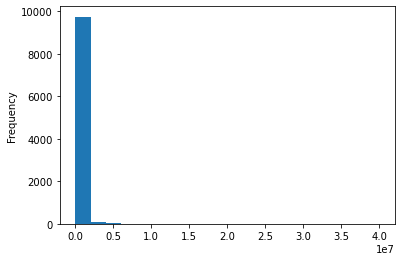

In [27]:
tech_mb2.latest_accounts_assets.plot.hist(bins=20)

In [28]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

In [29]:
#Initialise the Scalers and Transformers
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [30]:
tech_mbn = tech_mb2.copy()
for c in tech_mb2.columns.values:
    tech_mbn[c] = pts.fit_transform(tech_mb2[c].values.reshape(-1,1))
tech_mbn.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
oslaua,,,,,,,
S12000033,-0.21,-0.85,-0.29,0.69,1.04,3.02,-0.76
S12000033,-0.21,1.30,-0.29,1.08,1.26,3.02,-0.77
S12000033,-0.21,-0.85,-0.29,1.32,1.49,3.02,-0.76
S12000033,-0.21,-0.85,-0.29,1.16,1.75,3.02,-0.77
S12000033,-0.21,-0.85,-0.29,0.52,-0.72,3.02,-0.77


from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

#fit transform
tech_mbn = tech_mb1.copy()
for c in tech_mb1.columns.values:
    tech_mbn[c] = rs.fit_transform(tech_mb1[c].values.reshape(-1,1))
tech_mbn.head()

c_nm   = 'KMeans' # Clustering name
k_pref = 5 # Number of clusters (from below)

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(tech_mbn) # The process

print(kmeans.labels_) # The results

In [31]:
ssd = []

for k in range(2,15):
    
    model = KMeans(n_clusters=k)
    
    
    model.fit(tech_mbn)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

Text(0, 0.5, ' Sum of Squared Distances')

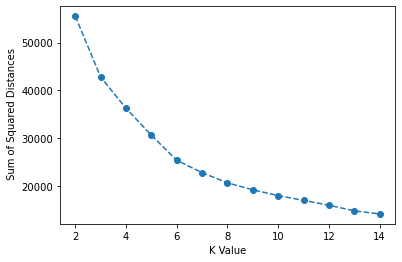

In [32]:
plt.plot(range(2,15),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

In [33]:
# Change in SSD from previous K value!
pd.Series(ssd).diff()

0           nan
1    -12,727.68
2     -6,563.94
3     -5,622.66
4     -5,266.37
5     -2,580.49
6     -2,141.11
7     -1,452.27
8     -1,219.45
9       -998.81
10    -1,024.44
11    -1,153.92
12      -655.93
dtype: float64

# evluation of k mean using silhouette analysis rather than elbow techniqu
#https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#gLADrc = gLADr.drop(list(gLADr.columns[gLADr.isnull().any().values].values), axis=1)

text = []

for k in range(3,12):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, n_init=15, random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(tech_mbn)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(tech_mbn, cluster_labels)
    text = text + [f"For k={k} the average silhouette_score is: {silhouette_avg:6.4f}"]
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(tech_mbn, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
    # The (n_clusters+1)*12 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, tech_mbn.shape[0] + (k + 1) * 12])
    
    y_lower = 12
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Set the color ramp
        #cmap  = cm.get_cmap("Spectral")
        color = plt.cm.Spectral(i/k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 12  # 12 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(cluster_labels.astype(float) / k)
    ax2.scatter(tech_mbn[tech_mbn.columns[0]], tech_mbn[tech_mbn.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

print("\n".join(text))    

del(tech_mbn)

In [34]:
tech_mbn = tech_mb2.copy()
for c in tech_mb2.columns.values:
    tech_mbn[c] = pts.fit_transform(tech_mb2[c].values.reshape(-1,1))
tech_mbn.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
oslaua,,,,,,,
S12000033,-0.21,-0.85,-0.29,0.69,1.04,3.02,-0.76
S12000033,-0.21,1.30,-0.29,1.08,1.26,3.02,-0.77
S12000033,-0.21,-0.85,-0.29,1.32,1.49,3.02,-0.76
S12000033,-0.21,-0.85,-0.29,1.16,1.75,3.02,-0.77
S12000033,-0.21,-0.85,-0.29,0.52,-0.72,3.02,-0.77


# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,20):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(tech_mbn)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(tech_mbn, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

In [35]:
#hence cluster k=7 is good where it is about to be flatten out, a lot less than previous k value

In [36]:
model = KMeans(n_clusters=7)
model.fit(tech_mbn)

KMeans(n_clusters=7)

In [37]:
model.labels_ # The results

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [38]:
tech_mbn['K=7 Clusters'] = model.labels_

In [39]:
tech_mbn.corr()['K=7 Clusters'].sort_values()

age                           -0.41
latest_accounts_cash          -0.12
lat                           -0.07
latest_accounts_assets        -0.02
latest_accounts_liabilities   -0.00
nr_employees_last_avail_yr     0.04
long                           0.09
K=7 Clusters                   1.00
Name: K=7 Clusters, dtype: float64

cluster_labels = model.fit_predict(tech_mbn)

len(tech_mbn)

tech_mb2['Cluster'] = cluster_labels

<AxesSubplot:>

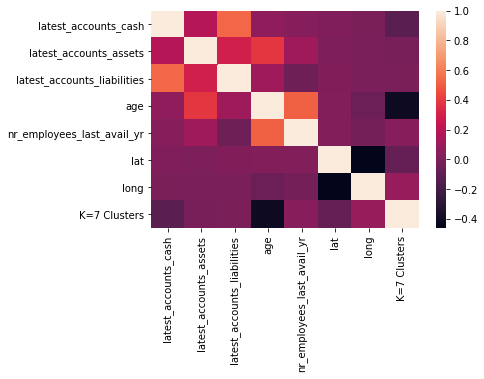

In [40]:
sns.heatmap(tech_mbn.corr())

In [42]:
tech_mbn['K=7 Clusters'].sort_values()

oslaua
E08000009    0
W06000013    0
W06000022    0
W06000013    0
W06000013    0
            ..
E07000012    6
E08000035    6
E07000198    6
E07000012    6
E06000015    6
Name: K=7 Clusters, Length: 9859, dtype: int32

In [43]:
#add coloumn to index
tech_mbn['location'] = tech_mbn.index

j = folium.Map(location = [51.505453, -0.268839])
folium.GeoJson('LAD.json').add_to(j)

j.save("j.html")#open with safari

we can see that the lad json is ok, no missing lad. hence, it is probably when merge lad, some lads left with no match for data
(this would leave no matching lad data and when mapping some lad area becomes blank)

In [44]:
lad=pd.read_csv('lad.csv')

In [45]:
tech_mbn = pd.merge(tech_mbn, lad, how = "outer", on=["location"])

In [46]:
tech_mbn = tech_mbn.fillna(0)
#still not showing for some lads bcos the json file contains outdated codes
#for instance, West Somerset code E07000246 is not in json file, it is E07000191 in the json which is inactive in real life

In [47]:
#replace string (too many) such as E07000246 to E07000191 and E07000190
#Perth & Kinross, whole Dorset, E07000190 Taunton Deane INACTIVE (Local Authority) E07000191 West Somerset INACTIVE (Local Authority)
#download ons2018 version

In [48]:
#tech_mb2_geo = pd.merge(tech_mb2, data_postcode, how="left", on=["oslaua"])

In [49]:
#pip install plotly==5.2.1

In [50]:
#pip install "jupyterlab>=3" "ipywidgets>=7.6"

In [51]:
with open('LAD.json', encoding="UTF-8") as json_file:
    LAD_json = json.load(json_file)

In [52]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

tech_mbn.to_csv("tech_mbn.csv")

import plotly.express as px

fig = px.choropleth(tech_mb2, locations="location",
                    color="Cluster", # lifeExp is a column of gapminder
                    #hover_name="Country", # column to add to hover information
                    color_continuous_scale='Turbo'
                    )
fig.show()

In [ ]:
fig = px.choropleth_mapbox(tech_mbn, geojson=LAD_json, locations=tech_mbn.location, color='K=7 Clusters',featureidkey="properties.LAD13CD",
                           color_continuous_scale="Viridis",
                           range_color=(0, 7),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 51.505453, "lon": -0.268839},
                           opacity=0.5,
                           labels={'comp':'no.comp'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Processing cluster 0.0
Processing cluster 1.0
Processing cluster 2.0
Processing cluster 3.0
Processing cluster 4.0
Processing cluster 5.0
Processing cluster 6.0


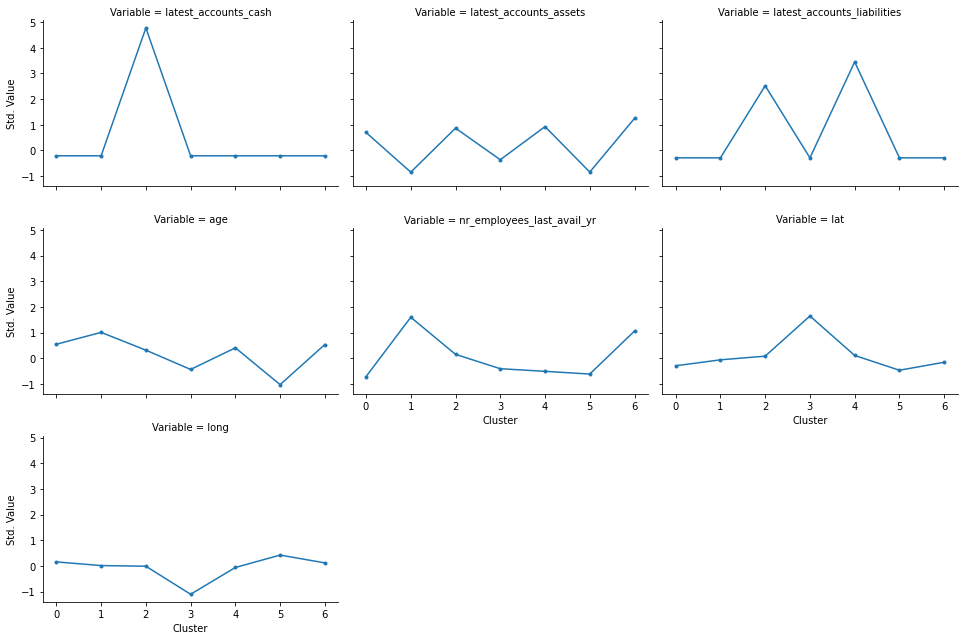

In [90]:
centroids = None
for k in sorted(tech_mbn['K=7 Clusters'].unique()):
    print(f"Processing cluster {k}")

    clsoas = tech_mbn[tech_mbn['K=7 Clusters']==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index('K=7 Clusters')
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

# Drop outliers
odf = odf[odf.Cluster >= 0]
odf.drop(index=odf[odf.Variable.isin(['geometry','KMeans'])].index, inplace=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids)

In [101]:
cluster2 = tech_mbn[tech_mbn['K=7 Clusters'] ==2]
cluster4 = tech_mbn[tech_mbn['K=7 Clusters'] ==4]

In [102]:
cluster4

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long,K=7 Clusters,location,FID,LAD20NM,LAD20NMW
45,-0.21,0.73,3.45,1.47,-0.72,2.95,-0.82,4.00,S12000034,126.00,Aberdeenshire,0
70,-0.21,1.38,3.45,0.61,1.85,-0.25,0.64,4.00,E07000241,76.00,Welwyn Hatfield,0
93,-0.21,1.20,3.45,-0.04,1.04,-0.31,0.55,4.00,E07000240,75.00,St Albans,0
97,-0.21,1.16,3.45,0.99,-0.72,-0.38,0.50,4.00,E07000240,75.00,St Albans,0
123,-0.21,1.10,3.45,0.15,1.55,-0.38,0.48,4.00,E07000240,75.00,St Albans,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9629,-0.21,1.22,3.45,-0.28,-0.72,-0.69,0.44,4.00,E07000213,265.00,Spelthorne,0
9665,-0.21,1.12,3.45,0.77,1.40,1.01,-0.99,4.00,E06000007,8.00,Warrington,0
9673,-0.21,1.23,3.45,-0.04,-0.72,0.94,-1.00,4.00,E06000007,8.00,Warrington,0
9715,-0.21,1.34,3.45,0.30,-0.72,1.19,-0.40,4.00,E08000036,329.00,Wakefield,0


In [ ]:
#tech_mb2_geo = pd.merge(tech_mb2, data_postcode, how="left", on=["oslaua"])

In [ ]:
#tech_mb2_geo.plot(column='Cluster', categorical=True, legend=True, figsize=(12,8));

## DBSCAN

TASK: Use DBSCAN and a for loop to create a variety of models testing different epsilon values. Set min_samples equal to 2 times the number of features. During the loop, keep track of and log the percentage of points that are outliers. For reference the solutions notebooks uses the following range of epsilon values for testing:

np.linspace(0.001,3,50)

In [56]:
tech_mbdb = tech_mb1.copy()
tech_mbdb = tech_mbdb.drop(list(tech_mbdb.columns[tech_mbdb.isnull().any().values].values), axis=1)#axis=1 for dropping coloumn of null
#tech_mbdb = tech_mbdb[tech_mbdb['latest_accounts_assets']>0]
#tech_mbdb = tech_mbdb.drop(['primary_uk_sic_2007','latest_accounts_cash'],axis=1)

In [57]:
tech_mbdb.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
oslaua,,,,,,,
S12000033,0.00,0.00,0.00,9.00,2.00,57.14,-2.11
S12000033,0.00,"95,232.00",0.00,16.00,3.00,57.14,-2.11
S12000033,0.00,0.00,0.00,23.00,5.00,57.14,-2.11
S12000033,0.00,0.00,0.00,18.00,13.00,57.15,-2.12
S12000033,0.00,0.00,0.00,7.00,0.00,57.15,-2.12


In [58]:
outlier_percent = []

for eps in np.linspace(0.001,3,50):
    
    # Create Model
    dbscan = DBSCAN(eps=eps, min_samples=tech_mbdb.shape[1]+1)#min_samples=tech_mbdb1.shape[1]+1)
    dbscan.fit(tech_mbdb)
   
     
    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

Text(0.5, 0, 'Epsilon Value')

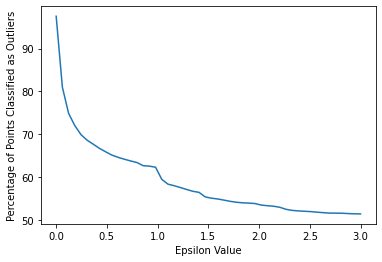

In [59]:
#Create a line plot of the percentage of outlier points versus the epsilon value choice.
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")

Based on the plot created, retrain a DBSCAN model with a reasonable epsilon value eps=2.5

In [60]:
dbscan = DBSCAN(eps=2)
dbscan.fit(tech_mbdb)

DBSCAN(eps=2)

In [61]:
#Create a new column on the original dataframe called "Labels" consisting of the DBSCAN labels
tech_mbdb['Labels'] = dbscan.labels_

In [62]:
tech_mbdb.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long,Labels
oslaua,,,,,,,,
S12000033,0.00,0.00,0.00,9.00,2.00,57.14,-2.11,0
S12000033,0.00,"95,232.00",0.00,16.00,3.00,57.14,-2.11,-1
S12000033,0.00,0.00,0.00,23.00,5.00,57.14,-2.11,-1
S12000033,0.00,0.00,0.00,18.00,13.00,57.15,-2.12,-1
S12000033,0.00,0.00,0.00,7.00,0.00,57.15,-2.12,0


In [63]:
#Compare the statistical mean of the clusters and outliers for the spending amounts on the categories
dbv = tech_mbdb[['latest_accounts_cash','latest_accounts_assets','latest_accounts_liabilities','age','nr_employees_last_avail_yr','Labels','lat','long']]
dbv_means = dbv.groupby('Labels').mean()

In [64]:
dbv_means

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
Labels,,,,,,,
-1,"12,152.76","224,556.45","20,855.21",12.84,35.79,52.35,-1.28
0,0.00,0.01,0.00,2.98,0.39,52.26,-1.12
1,0.00,0.00,0.00,30.90,6.50,51.78,-0.77
2,0.00,0.00,0.00,16.40,54.20,53.87,-2.24
3,0.00,100.00,0.00,2.13,0.00,51.73,-0.23
4,0.00,0.00,0.00,6.15,13.38,51.67,-0.22
5,0.00,0.00,0.00,27.75,5.25,51.68,-0.38
6,0.00,0.00,0.00,39.55,0.09,51.80,-0.53
7,100.00,0.00,0.00,1.22,0.00,51.81,-0.51


In [65]:
scaler = MinMaxScaler()
data = scaler.fit_transform(dbv_means)
scaled_means = pd.DataFrame(data,dbv_means.index,dbv_means.columns)

In [66]:
scaled_means

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long
Labels,,,,,,,
-1,1.00,1.00,1.00,0.26,0.66,0.43,0.45
0,0.00,0.00,0.00,0.04,0.01,0.40,0.52
1,0.00,0.00,0.00,0.67,0.12,0.22,0.69
2,0.00,0.00,0.00,0.35,1.00,1.00,0.00
3,0.00,0.00,0.00,0.02,0.00,0.20,0.94
4,0.00,0.00,0.00,0.11,0.25,0.18,0.95
5,0.00,0.00,0.00,0.60,0.10,0.18,0.87
6,0.00,0.00,0.00,0.87,0.00,0.23,0.80
7,0.01,0.00,0.00,0.00,0.00,0.23,0.81


<AxesSubplot:ylabel='Labels'>

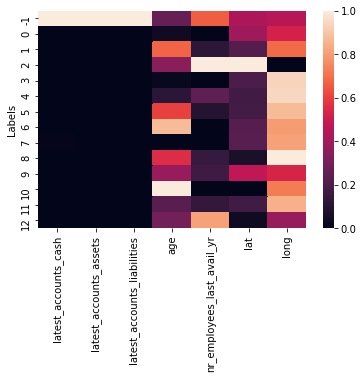

In [67]:
sns.heatmap(scaled_means)

<AxesSubplot:ylabel='Labels'>

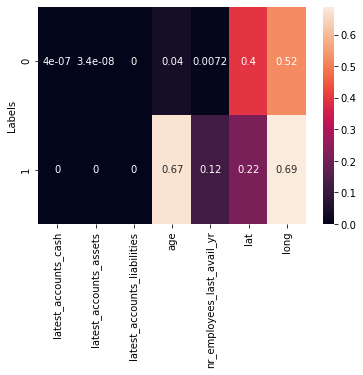

In [68]:
#with outliner removed
sns.heatmap(scaled_means.loc[[0,1]],annot=True)

# we can find that the two clusters mode different in age the most signifcant

There are two values that need to be specified: eps and min_samples. Both seem to be set largely by trial and error. It's easiest to set min_samples first since that sets a floor for your cluster size and then eps is basically a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

In [69]:
c_nm = 'DBSCAN'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
tech_mbdb1 = tech_mbdb.drop(list(tech_mbdb.columns[tech_mbdb.isnull().any().values].values), axis=1)

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

# There's an argument for making min_samples = len(df.columns)+1

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.15, 1.55, 0.01):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=tech_mbdb.shape[1]+1).fit(tech_mbdb1.values)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=tech_mbdb1.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    for c in range(-1, max_clusters+1):
        try:
            row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])
edf.sample(random_state=42)

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

0 epsilons explored.
25 epsilons explored.
50 epsilons explored.
75 epsilons explored.
100 epsilons explored.
125 epsilons explored.
Done.


In [70]:
e = 2
dbs = DBSCAN(eps=e, min_samples=tech_mbdb.shape[1]+1).fit(tech_mbdb1.values)
s = pd.Series(dbs.labels_, index=tech_mbdb1.index, name=c_nm)
tech_mbdb1[c_nm] = s
print(s.value_counts())

-1    5329
 0    4484
 1      22
 3      12
 2      12
Name: DBSCAN, dtype: int64


In [71]:
def plt_ldn(b):
    fig, ax = plt.subplots(1, figsize=(18, 26))
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

In [72]:
#LAD Geopackage
data = os.path.join('data','geo','localauth.json')
if not os.path.exists(data):
    localauth = gpd.read_file('https://raw.githubusercontent.com/supernovajon/tech-cluster/main/LAD.json')
    print("Downloaded localauth.json file.")
else:
    localauth = gpd.read_file(data)

Downloaded localauth.json file.


In [73]:
tech_mbdb1.head()

,latest_accounts_cash,latest_accounts_assets,latest_accounts_liabilities,age,nr_employees_last_avail_yr,lat,long,Labels,DBSCAN
oslaua,,,,,,,,,
S12000033,0.00,0.00,0.00,9.00,2.00,57.14,-2.11,0,-1
S12000033,0.00,"95,232.00",0.00,16.00,3.00,57.14,-2.11,-1,-1
S12000033,0.00,0.00,0.00,23.00,5.00,57.14,-2.11,-1,-1
S12000033,0.00,0.00,0.00,18.00,13.00,57.15,-2.12,-1,-1
S12000033,0.00,0.00,0.00,7.00,0.00,57.15,-2.12,0,0


In [74]:
#add coloumn to index
tech_mbdb1['LAD13CD'] = tech_mbdb1.index

In [75]:
#add geometry
tech_mbdb2 = pd.merge(localauth, tech_mbdb1, how="left", on=["LAD13CD"])

fig, ax = plt_ldn(localauth)
fig.suptitle(f"{c_nm} Results", fontsize=10, y=0.92)
tech_mbdb2.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True);

fig.savefig("mbdbgeo.png", dpi=200)

In [85]:
cluster3 = tech_mbdb1[tech_mbdb1.DBSCAN ==3]

In [86]:
print(cluster3)

           latest_accounts_cash  latest_accounts_assets  \
oslaua                                                    
E08000025                  0.00                  100.00   
E06000043                  0.00                  100.00   
E07000008                  0.00                  100.00   
E07000008                  0.00                  100.00   
E09000030                  0.00                  100.00   
E09000003                  0.00                  100.00   
E09000007                  0.00                  100.00   
E06000034                  0.00                  100.00   
E07000211                  0.00                  100.00   
E09000032                  0.00                  100.00   
E09000033                  0.00                  100.00   
E09000033                  0.00                  100.00   

           latest_accounts_liabilities  age  nr_employees_last_avail_yr   lat  \
oslaua                                                                          
E08000025  

Hierarchical Clustering
Probably not appropriate as it tends to be confused by noise.

In [ ]:
#shown on map generally for latest account asset

In [ ]:
gdf = gpd.GeoDataFrame(tech_SIC_geo, 
      geometry=gpd.points_from_xy(tech_SIC_geo['long'], tech_SIC_geo['lat'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

gdf.plot(column='latest_accounts_assets', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(12,6));

In [ ]:
#groupby local authority district
gLAD = gdf.groupby(['oslaua','primary_uk_sic_2007'])['primary_uk_sic_2007'].agg(Count='count').reset_index() # oslaua companies grouped counts
gLAD.head(100)

In [ ]:
len(gLAD.index)

In [ ]:
#groupby local authority district
gLADt = gdf.groupby(['oslaua'])['primary_uk_sic_2007'].agg(Count='count').reset_index() # oslaua companies grouped counts
gLADt.head(100)

gLADt.to_csv('gLADt.csv')

In [ ]:
len(gLADt.index)

In [ ]:
#change coloumn name to match
cols = gLADt.columns.values
cols[0]  = 'LAD13CD'
cols[1]  = 'Counts'
gLADt.columns = cols

In [ ]:
gLADt.sample(3, random_state=42)

In [ ]:
gLADt.nsmallest(10,'Counts')

In [ ]:
#read LAD geojson

In [ ]:
with open('LAD.json', encoding="UTF-8") as json_file:
    LAD_json = json.load(json_file)

In [ ]:
print(gLADt["Counts"][2])
print(LAD_json["features"][0]["properties"])

In [ ]:
gLADt.nlargest(10,'Counts')

In [ ]:
#would show empty in chrome but works in safari due to folium issue in showing complex large datasets
bins = [0, 1000, 2000, 3000, 5000, 10000, 12000]
m = folium.Map(location=[55, 4], zoom_start=5)
m.choropleth(
    geo_data=LAD_json,
    data=gLADt,
    columns=['LAD13CD', 'Counts'],
    key_on='feature.properties.LAD13CD',
    fill_color='YlGn',
    threshold_scale = bins,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='no.of companies',
    highlight=True
)

In [ ]:
m.save("m.html")

In [ ]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

In [ ]:
#LAD Geopackage
data = os.path.join('data','geo','localauth.json')
if not os.path.exists(data):
    localauth = gpd.read_file('https://raw.githubusercontent.com/supernovajon/tech-cluster/main/LAD.json')
    print("Downloaded localauth.json file.")
else:
    localauth = gpd.read_file(data)

In [ ]:
#add ID
for k in range(len(LAD_json['features'])):
     LAD_json['features'][k]['id'] = k

In [ ]:
LAD_json['features'][0].keys()

In [ ]:
fig = px.choropleth_mapbox(gLADt, geojson=LAD_json, locations=gLADt.LAD13CD, color='Counts',featureidkey="properties.LAD13CD",
                           color_continuous_scale="Viridis",
                           range_color=(0, 3000),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 51.505453, "lon": -0.268839},
                           opacity=0.5,
                           labels={'comp':'no.comp'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
#add geometry to gLADt as a result set then plot
rs = pd.merge(localauth, gLADt, how="left", on=["LAD13CD"])

In [ ]:
rs

rs.to_csv('rs.csv')

In [ ]:
rs.nlargest(10,'Counts')

In [ ]:
rs.nsmallest(10,'Counts')

In [ ]:
#distribution of counts
sns.histplot(rs["Counts"])

In [ ]:
rs.isnull().sum()/len(data) *100 #values are missing in Counts for some LADs

In [ ]:
#fill na with 0 as it is numerical not categorical that needs dummy variables, 
#it simply indicates there is no high-tech company registered in the area here
rs = rs.fillna(0)

In [ ]:
bins = [0, 1, 100, 500, 1000, 2000, 5000, 12000]

In [ ]:
#new undeprecated way
#be aware that the tiles do not work here LAD_map = folium.Map(location=[55, 4], zoom_start=5, tiles='Mapbox Bright')
n = r'LAD.json' # geojson file

LAD_map = folium.Map(location=[55, 4], zoom_start=5)

# generate choropleth map
folium.Choropleth(
    geo_data=LAD_json,
    data=rs,
    columns=['LAD13CD', 'Counts'],
    key_on='feature.properties.LAD13CD',
    fill_color='YlGn',
    threshold_scale = bins,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='no.of companies',

).add_to(LAD_map)

In [ ]:
LAD_map

In [ ]:
LAD_map.save("LAD_map.html")

In [ ]:
rs["Counts"].mean()

In [ ]:
#zero count
zero_counts = sum(rs['Counts']==0)/rs[rs.Counts>=0].shape[0]*100
print('percentage of zero counts is: ',zero_counts, '%')

In [ ]:
#one count
one_counts = sum(rs['Counts']==1)/rs[rs.Counts>=0].shape[0]*100
print('percentage of one counts is: ',one_counts, '%')

In [ ]:
#smaller than 1000 count
x_counts = sum(rs['Counts']<813)/rs[rs.Counts>=0].shape[0]*100
print('percentage of 813 counts is: ',x_counts, '%')

In [ ]:
rs['Counts']<813

In [ ]:
##clustering

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

#Initialise the Scalers and Transformers
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [ ]:
#gLADr is for changing the format for readability and (analyse specific SIC industry) analyse links between tech industries
gLADr = gLAD.pivot(index='oslaua', columns=['primary_uk_sic_2007'], values=['Count']).reset_index()
gLADr.columns = ['LAD13CD',26511,26513,26600,26701,32500,72190,74202,21100,21200,72110,
                                                       62020,62030,62090,63110,26301,26309,61900,26200,26110,26400,26512,
                                                       27110,27200,27310,27900,28910,71121,71122,71200,74100,74901,28110,
                                                       28120,28131,28132,28150,29100,29201,29202,29310,29320,30110,30120,
                                                       30200,30300,30400,59111,59112,59113,59120,59200,18201,18202,18203,
                                                       58210,58290,62011,62012,63120,64301,64302,64303,64304,64305,64306,
                                                       64921,64992,64999,65300]
gLADr.head()

In [ ]:
gLADr = gLADr.replace(np.nan, 0)

In [ ]:
#search for random gLADr
gLADr.sample(3, random_state=42)

gLADr.to_csv('gLADr.csv')

In [ ]:
#add coloumn of total sum and HHI


In [ ]:
#Counts are so skewed that using it in most clustering contexts is almost impossible. the reason for using the PowerTransformer

In [ ]:
# reset index to LAD13CD
gLADrc = gLADr.fillna(0).set_index('LAD13CD')

In [ ]:
gLADrc

In [ ]:
#then transform
for c in gLADrc.columns.values:
    gLADrc[c] = pts.fit_transform(gLADrc[c].values.reshape(-1,1))
gLADrc.head(10)

In [ ]:
cols_to_plot = np.random.choice(gLADrc.columns.values, 4, replace=False)
print(cols_to_plot)

In [ ]:
cols_to_plot

In [ ]:
#variable SIC code industry classification
bio_cols = [21100,21200,72110]

## First K-Means Clustering

In [ ]:
c_nm   = 'KMeans' # Clustering name
k_pref = 6 # Number of clusters (from below)

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gLADrc) # The process

print(kmeans.labels_) # The results

In [ ]:
rss = pd.merge(localauth, gLADrc, left_on='LAD13CD', right_index=True).set_index('LAD13CD')

In [ ]:
rss.head(2)[[26511,26513]]

In [ ]:
# Add it to the data frame
rss[c_nm] = pd.Series(kmeans.labels_, index=gLADrc.index)

In [ ]:
rss

In [ ]:
# How are the clusters distributed
ax = sns.histplot(data=rss, x=c_nm, bins=k_pref);

In [ ]:
# Going to be a bit hard to read if plot every variable against everyother variables, so we'll just pick a random col_to_plot
sns.set(style="white")
sns.pairplot(rss, 
             vars=bio_cols, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

In [ ]:
from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
sklv = int(sklearn.__version__.replace(".",""))
if sklv < 210:
    print("SciKit-Learn verion is: " + sklearn.__version__)
    print("The OPTICS part of this notebook relies on a version >= 0.21.0")

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
from sklearn import cluster

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [ ]:
def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [ ]:
breaks = np.arange(0,rss[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))

norm    = mpl.colors.BoundaryNorm(breaks, cmap.N)

fig, ax = plt_ldn(localauth)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rss.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

del(rss)

In [ ]:
#above used 3. choose the right cluster number with silhouette_score

The 'Right' Number of Clusters

Again, there's more than one way to skin this cat. In Geocomputation they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try it for the range 3-9.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

In [ ]:
# evluation of k mean using silhouette analysis rather than elbow techniqu
#https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#gLADrc = gLADr.drop(list(gLADr.columns[gLADr.isnull().any().values].values), axis=1)

text = []

for k in range(3,10):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, n_init=15, random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(gLADrc)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(gLADrc, cluster_labels)
    text = text + [f"For k={k} the average silhouette_score is: {silhouette_avg:6.4f}"]
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(gLADrc, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, gLADrc.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Set the color ramp
        #cmap  = cm.get_cmap("Spectral")
        color = plt.cm.Spectral(i/k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(cluster_labels.astype(float) / k)
    ax2.scatter(gLADrc[gLADrc.columns[0]], gLADrc[gLADrc.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

print("\n".join(text))    

del(gLADrc)

In [ ]:
#using k=6 as the presence of clusters with higher average silhouette scores 
#and also due to wide fluctuations in the size of the silhouette plots

In [ ]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(gLADrc)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(gLADrc, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

#### DB SCAN

In [ ]:
gLADrc2 = gLADrc[[21100,21200]]
gLADrc2.head(100)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=2).fit(gLADrc2)
distances, indices = nbrs.kneighbors(gLADrc2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.gcf().suptitle("Nearest Neighbour Distances");

In [ ]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.025, 0.25, 0.005):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=gLADrc2.shape[1]+1).fit(gLADrc2)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=gLADrc2.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

In [ ]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)

odf['Count'] = odf.Count.astype(float)

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster');
ax.vlines(0.06, 0, ax.get_ylim()[1], linestyle='dashed', color='r');

In [ ]:
e = 0.06
dbs = DBSCAN(eps=e, min_samples=gLADrc2.shape[1]+1).fit(gLADrc2.values)
s = pd.Series(dbs.labels_, index=gLADrc2.index, name=c_nm)
rss[c_nm] = s
print(s.value_counts())

In [ ]:
fig, ax = plt_ldn(localauth)
fig.suptitle(f"{c_nm} Results", fontsize=10, y=0.92)
rss.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True);

In [ ]:
def plt_ldn(b):
    fig, ax = plt.subplots(1, figsize=(14, 22))
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

In [ ]:
#Freeing Up Memory - free up some RAM by getting rid of some variables and datasets
in_scope  = set([x for x in dir() if not x.startswith('_')])
to_delete = set(['raw','clean','transformed','col','k','c','lsoac','scdf'])
z = list(in_scope.intersection(to_delete))
del(z)

data_3=pd.read_csv('OC_3.1.csv')